# Operation Modes on XyloAudio 3


### Preface: Creating and loading a network in XyloAudio 3

Samna version 0.39.6.0
from samna.xyloA3.configuration import InputInterfaceConfig
The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`
[<samna.xyloAudio3.XyloAudio3TestBoard object at 0x73cce8e849b0>] [<module 'rockpool.devices.xylo.syns65302' from '/home/vleite/SynSense/rockpool/rockpool/devices/xylo/syns65302/__init__.py'>] ['syns65302']


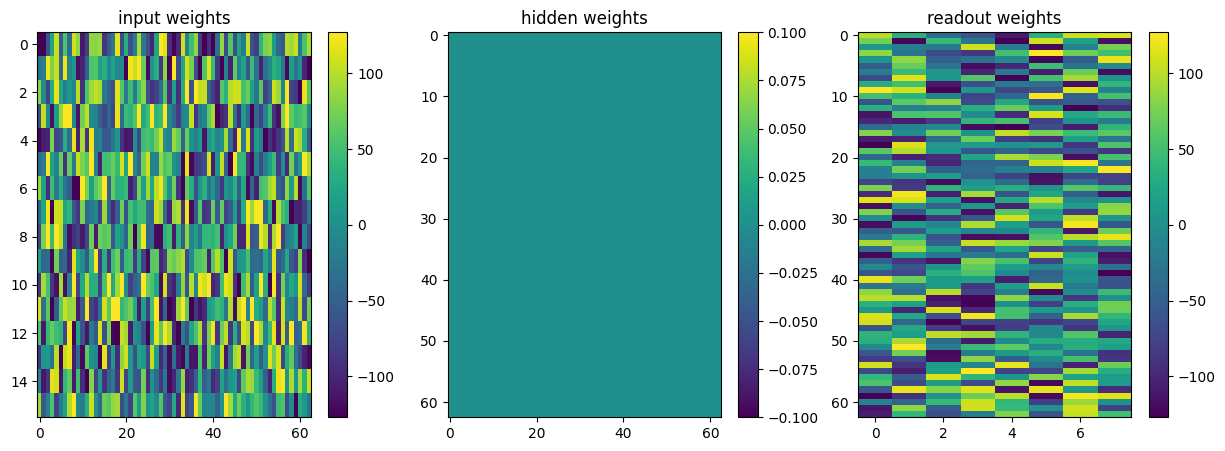

In [1]:
import samna
print(f'Samna version {samna.__version__}')

import numpy as np
import matplotlib.pyplot as plt
from rockpool.transform.quantize_methods import channel_quantize
from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential
from rockpool.devices.xylo import find_xylo_hdks
from rockpool.devices.xylo.syns65302 import config_from_specification as config_from, mapper as mapper, XyloSamna as XyloSamna, XyloMonitor as XyloMonitor

net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),
    Linear((63, 8)),
    LIF(8),
)

xylo_hdks, xylo_support_modules, xylo_versions = find_xylo_hdks()
print(xylo_hdks, xylo_support_modules, xylo_versions)

device = ""
for version, xylo in zip(xylo_versions, xylo_hdks):
    if version == "syns65302":
        device = xylo

print(device) if device else print("No XyloAudio 3 was found.")

if device:
    spec = mapper(net.as_graph())
    Q_spec = spec
    Q_spec.update(channel_quantize(**Q_spec))
    config, is_valid, msg = config_from(**Q_spec)
    
    if not is_valid:
        print(msg)

    w_in = config.input.weights
    w_hid = config.hidden.weights
    w_out = config.readout.weights
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(w_in, aspect='auto'); plt.colorbar(); plt.title('input weights')
    plt.subplot(132)
    plt.imshow(w_hid, aspect='auto');plt.colorbar(); plt.title('hidden weights')
    plt.subplot(133)
    plt.imshow(w_out, aspect='auto');plt.colorbar(); plt.title('readout weights')



## Real-time

In real-time mode, XyloAudio 3 continuously processes events as they are received.
Events are received directly from one of the onboard microphones instead of event-based input.

In this mode, the chip operates autonomously, collecting inputs and processing them. Once the processing is done, the XyloAudio 3 outputs all generated spike events. It is not possible to interact with the chip during this period. Thus, the collection of internal neuron states is not permitted.


In [2]:
# the time window of a processing step in seconds
dt = 0.01
# operation mode is RealTime
config.operation_mode = samna.xyloAudio3.OperationMode.RealTime

# Deploy the network and initialize real-time monitoring class
xylo_monitor = XyloMonitor(device=device, config=config, dt = dt, output_mode = "Spike")
print(xylo_monitor)

XyloMonitor  with shape (16, 63, 8)


In [3]:
# for how long we will listen to an audio signal, in seconds
timeout = 5 

# - Evolve the network on the Xylo HDK
out, _, rec = xylo_monitor.evolve(record=False, record_power=True, read_timeout=timeout)

# - Show the keys from the recorded dictionary
print(rec.keys())


dict_keys(['io_power', 'analog_power', 'digital_power'])


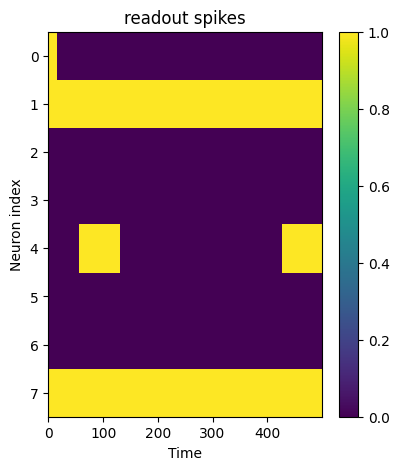

In [4]:
# - Plot the output spikes

plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()

## Accelerated-time

In accelerated-time mode we can give a specific input to XyloAudio that will be processed as quickly as possible, while allowing the monitoring of internal network state.
This mode is ideal for benchmarking and validating models.

In accelerated-time, the input has to be a list of spike events ordered by timestep. 


### Preface: Loading an input data

In accelerated-time mode we bypass the microphone and input data directly to the SNN core.

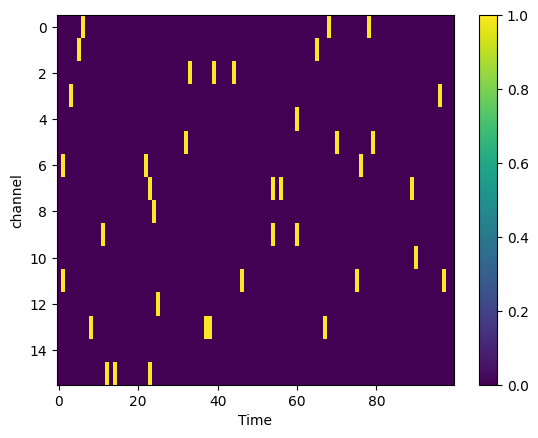

In [5]:
T = 100  #number of time steps
dt = 0.01 #size of time step
Nin = 16 # number of input channels 
p = 0.02 # spiking probability
input_data = np.random.rand(T,Nin) > (1-p)
input_data = np.array(input_data, dtype=bool)

plt.figure()
plt.imshow(input_data.T, aspect='auto'); plt.xlabel('Time'); plt.ylabel('channel'); plt.colorbar()



In [6]:
# - Set operation mode to AcceleratedTime
config.operation_mode = samna.xyloAudio3.OperationMode.AcceleratedTime
# - In accelerated mode, the input source is a list of SpikeEvents
config.input_source   = samna.xyloAudio3.InputSource.SpikeEvents

# - The time window of a processing step in seconds
dt = 0.01
# - Record and return all internal states of the neurons and synapses on Xylo
record = True

xylo_samna = XyloSamna(device, config, dt = dt, record = record)    
print(xylo_samna)

XyloSamna  with shape (16, 63, 8)


In [7]:
# - Evolve the network on the Xylo HDK
xylo_samna.reset_state()
out, _, rec = xylo_samna.evolve(input_data)

# - Show the keys from the recorded dictionary
print(rec.keys())

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out'])


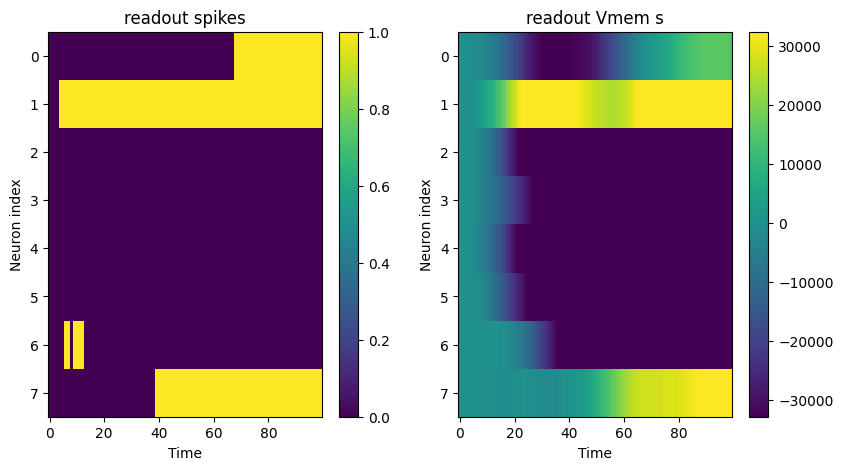

In [8]:
# - Plot the output spikes

plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()
plt.subplot(132), plt.imshow(rec['Vmem_out'].T, aspect='auto', interpolation='none');  plt.title('readout Vmem s'); plt.xlabel('Time'); plt.ylabel('Neuron index');  plt.colorbar()


## Manual


Manual mode operates similarly to accelerated-time mode, also by processing given input.
However, in manual mode, XyloAudio doesn't process the timesteps as fast as possible. Instead, timesteps are advanced by user configuration.
Manual mode offers complete control over the chip and can be used for debugging.

In this step, we will use the same input data generated for the accelerated-time mode.


In [9]:
# - Set operation mode to Manual
config.operation_mode = samna.xyloAudio3.OperationMode.Manual
# - In manual mode, the input source is a list of SpikeEvents
config.input_source   = samna.xyloAudio3.InputSource.SpikeEvents

# - The time window of a processing step in seconds
dt = 0.01
# - Record and return all internal states of the neurons and synapses on Xylo
record = True

xylo_samna = XyloSamna(device, config, dt = dt, record = record)    
print(xylo_samna)

WARNING    /home/vleite/SynSense/rockpool/rockpool/devices/xylo/syns65302/xylo_samna.py:420: UserWarning: `operation_mode is set to Manual. This mode can be used for debug purpuses together with `_evolve_manual`. Otherwise, please use `AccelerateTime`.
  warn(
 [py.warnings]
  warn(



XyloSamna  with shape (16, 63, 8)


In [10]:
# - Evolve the network on the Xylo HDK
xylo_samna.reset_state()
out, _, rec = xylo_samna._evolve_manual(input_data)

# - Show the keys from the recorded dictionary
print(rec.keys())

  0%|          | 0/100 [00:00<?, ?it/s]

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out'])


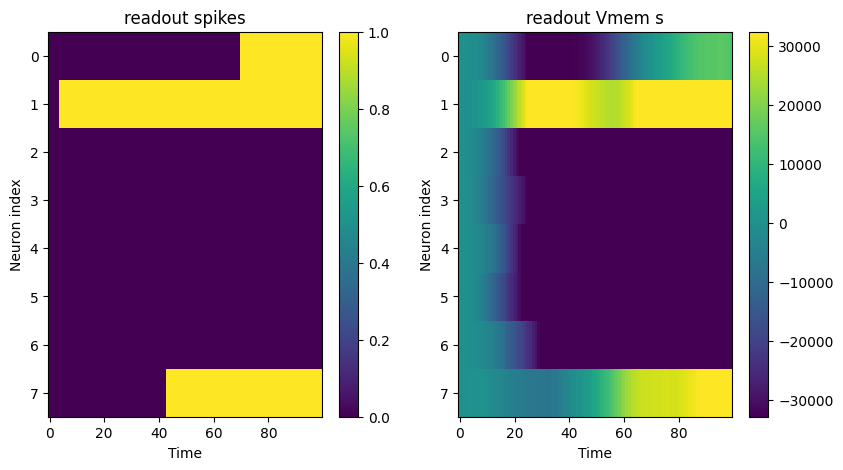

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()
plt.subplot(132), plt.imshow(rec['Vmem_out'].T, aspect='auto', interpolation='none');  plt.title('readout Vmem s'); plt.xlabel('Time'); plt.ylabel('Neuron index');  plt.colorbar()

# Converting audio samples to XyloAudio input